
<h1 style='background:#2cab6c; border:0; color:white'><center>Mengimport Library</center></h1>

In [1]:
import os

import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from pathlib import Path
from tqdm import tqdm

<h1 style='background:#2cab6c; border:0; color:white'><center>Paths, files</center></h1>

In [2]:
# Paths to the base directories/files of the dataset
base_dir = Path('/kaggle/input/cassava-leaf-disease-classification')
train_img_dir = f'{base_dir}/train_images'
test_img_dir = f'{base_dir}/test_images'

In [3]:
# Read train csv and json files with labels mapped to disease names
train_df = pd.read_csv(f'{base_dir}/train.csv')
disease_mapping = pd.read_json(f'{base_dir}/label_num_to_disease_map.json', typ='series')

In [4]:
# Create lists with all train and test images
train_images = os.listdir(f'{base_dir}/train_images/')
test_images = os.listdir(f'{base_dir}/test_images/')

<h1 style='background:#2cab6c; border:0; color:white'><center>Labels Mapping, Training Dataset</center></h1>

In [5]:
# Convert mapping to dict
mapping_dict = disease_mapping.to_dict()

In [6]:
# Show dict
mapping_dict

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

As you can see, the dataset contains 5 classes

In [7]:
# Show first 10 lines of train dataset
train_df.head(10)

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
5  1000837476.jpg      3
6  1000910826.jpg      2
7  1001320321.jpg      0
8  1001723730.jpg      4
9  1001742395.jpg      3

We can see the name of the images and their class labels here. The labels are represented as numbers, but for convenience we can replace them with the appropriate names.

In [8]:
# Let's check for any missing values in the train labels
missing = train_df.isnull().sum()
all_value = train_df.count()

missing_df = pd.concat([missing, all_value], axis=1, keys=['Missing Val.', 'All Val.'])
missing_df

Missing Val.  All Val.
image_id             0     21397
label                0     21397

You can see that there are no missing in the data.

In [9]:
# Let's replace numeric labels in dataset with disease names
train_df = train_df.replace(mapping_dict)

In [10]:
# Show first 10 lines of train dataset with replaced labels
train_df.head(10)

image_id                                label
0  1000015157.jpg       Cassava Bacterial Blight (CBB)
1  1000201771.jpg         Cassava Mosaic Disease (CMD)
2   100042118.jpg  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg         Cassava Mosaic Disease (CMD)
5  1000837476.jpg         Cassava Mosaic Disease (CMD)
6  1000910826.jpg           Cassava Green Mottle (CGM)
7  1001320321.jpg       Cassava Bacterial Blight (CBB)
8  1001723730.jpg                              Healthy
9  1001742395.jpg         Cassava Mosaic Disease (CMD)

In [11]:
# Let's count the num of training samples for each label
label_counts = train_df['label'].value_counts().reset_index()
label_counts.columns = ['Label', 'Num. of Observations']

# Create Pie Chart
fig = px.pie(label_counts,
             names='Label', values='Num. of Observations',
             labels=mapping_dict,
             title='Percentage Distribution of Labels in the Training Dataset')
fig.show()

You can see that the dataset contains a significant class imbalance, where most of the images are of the Cassava Mosaic Disease (CMD) class.

The dataset contains only 12% of the data with images of healthy leaves, while all other images are for diseased leaves.

In [12]:
# Let's check if the dataset contains duplicate images
unique_idx = train_df['image_id'].nunique()

if unique_idx == len(train_df):
    print('There are no duplicate image indices in the training dataset.')
else:
    print(f'There are {len(train_df) - unique_idx} duplicate image indices in the training dataset.')

There are no duplicate image indices in the training dataset.


<h1 style='background:#2cab6c; border:0; color:white'><center>Training Image Dataset</center></h1>

In [13]:
# Let's check how many images are in the training dataset
print(f'{len(train_images)} training images contains dataset.')

21397 training images contains dataset.


In [14]:
# Let's check the resolution of the images to make sure they're all standardized
imgs_shape = []

for img in tqdm(train_images):
    image = cv.imread(f'{base_dir}/train_images/{img}')
    imgs_shape.append(image.shape)
    
print(f'The training set contains the following unique image shapes: {set(imgs_shape)}')

100%|██████████| 21397/21397 [05:04<00:00, 70.33it/s]

The training set contains the following unique image shapes: {(600, 800, 3)}


We can see that all the images have the same shape: 600 by 800 pixels with 3 channels.

In [15]:
# Let's break the training dataset into separate lists with images for each class
healthy_imgs = train_df[train_df['label'] == 'Healthy']['image_id'].to_list()
cmd_imgs = train_df[train_df['label'] == 'Cassava Mosaic Disease (CMD)']['image_id'].to_list()
cgm_imgs = train_df[train_df['label'] == 'Cassava Green Mottle (CGM)']['image_id'].to_list()
cbsd_imgs = train_df[train_df['label'] == 'Cassava Brown Streak Disease (CBSD)']['image_id'].to_list()
cbb = train_df[train_df['label'] == 'Cassava Bacterial Blight (CBB)']['image_id'].to_list()

Next, we will implement a couple of helper functions for displaying images and their color histograms.

In [ ]:
def show_img(imgs_list, title):
    """Function for displaying images
    
    Args:
        img_list (list): a list that contains the names of the image files
        title (str): class label name
    """
    images = [np.random.choice(imgs_list) for i in range(6)]
    
    plt.figure(figsize=(12, 12))
    plt.suptitle(title, fontsize=24)
    
    for i in range(6):
        plt.subplot(3, 3, i+1)
        img = plt.imread(f'{train_img_dir}/{images[i]}')
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()

: 

In [17]:
def show_hist(imgs_list, title):
    """Function to display a random image from a dataset and its histogram of color channels
    
    Args:
        img_list (list): a list that contains the names of the image files
        title (str): class label name
    """
    image = np.random.choice(imgs_list)
    
    fig = plt.figure(figsize=(12, 12))
    
    fig.add_subplot(1, 2, 1)
    
    img = plt.imread(f'{train_img_dir}/{image}')
    
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    print(f'Image dimensions: {img.shape[0], img.shape[1]}',
          f'Max pixel value: {img.max()}',
          f'Min pixel value: {img.min()}',
          f'Mean pixel value: {round(img.mean())}',
          f'Standard deviation: {round(img.std())}', sep='\n')
    
    fig.add_subplot(1, 2, 2)
    
    plt.hist(img[:, :,  0].ravel(), bins=256, color='red', alpha=0.5)
    plt.hist(img[:, :,  1].ravel(), bins=256, color='green', alpha=0.5)
    plt.hist(img[:, :,  2].ravel(), bins=256, color='blue', alpha=0.5)
    
    plt.xlabel('Intensity Value')
    plt.ylabel('Count')
    plt.legend(['Red Channel', 'Green Channel', 'Blue Channel'])
    
    plt.show()

In [18]:
def get_rgb_image(image_idx):
    """Function for getting a NumPy Array of an image and converting it from BGR to RGB
    
    Args:
        image_idx (str): image file name
        
    Returns:
        ndarray: NumPy Array of an image
    """
    img = cv.imread(f'{train_img_dir}/{image_idx}')
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

In [19]:
def get_histograms_data(imgs_list):
    """Function for getting median values of color channels of input images
    
    Args:
        img_list (list): a list that contains the names of the image files
        
    Returns:
        list: a list that contains the median values of the color channels of images
    """
    img = [get_rgb_image(image_idx) for image_idx in imgs_list]
    
    red_values = [np.mean(img[idx][:, :, 0]) for idx in range(len(img))]
    green_values = [np.mean(img[idx][:, :, 1]) for idx in range(len(img))]
    blue_values = [np.mean(img[idx][:, :, 2]) for idx in range(len(img))]
    all_mean_values = [np.mean(img[idx]) for idx in range(len(img))]
    
    return [red_values, green_values, blue_values, all_mean_values]

In [20]:
def show_box_plot(imgs_list, title):
    """Function for displaying box-plots of histogram of color channels of images
    
    Args:
        img_list (list): a list that contains the names of the image files
        title (str): class label name
    """
    fig_data = []
    hist_data = get_histograms_data(imgs_list)
    
    for i, name in zip(range(3), ['Red', 'Green', 'Blue']):
        mark = go.Box(y=hist_data[i],
                      name=name,
                      boxpoints='all',
                      marker_color=name)
        fig_data.append(mark)
    
    fig = go.Figure(fig_data)
    fig.update_layout(title_text=f'{title} - Distribution of Pixel Values')
    fig.show()

<h1 style='background:#2cab6c; border:0; color:white'><center>Test Image Dataset</center></h1>

In [21]:
# Let's check how many images the test dataset contains
print(f'The training set contains {len(test_images)} image.')

The training set contains 1 image.


As you can see, the test case contains only one image. Therefore, when training the model, we will need to split the training dataset into test and validation.

Also, as stated in the description of the Kaggle competition, the test set contains 15k images, and it becomes available only after we send our notebook for scoring.

<h1 style='background:#2cab6c; border:0; color:white'><center>Healthy</center></h1>

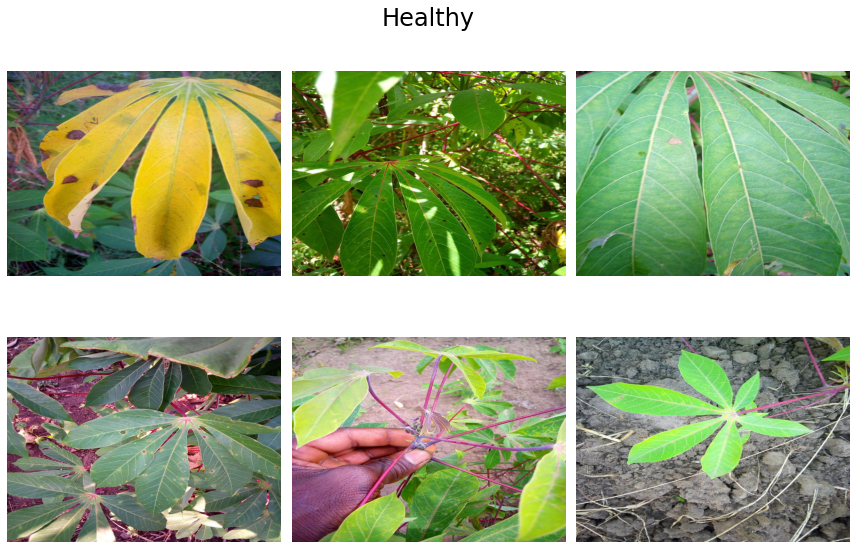

In [22]:
show_img(healthy_imgs, 'Healthy')

Image dimensions: (600, 800)
Max pixel value: 255
Min pixel value: 0
Mean pixel value: 114
Standard deviation: 68


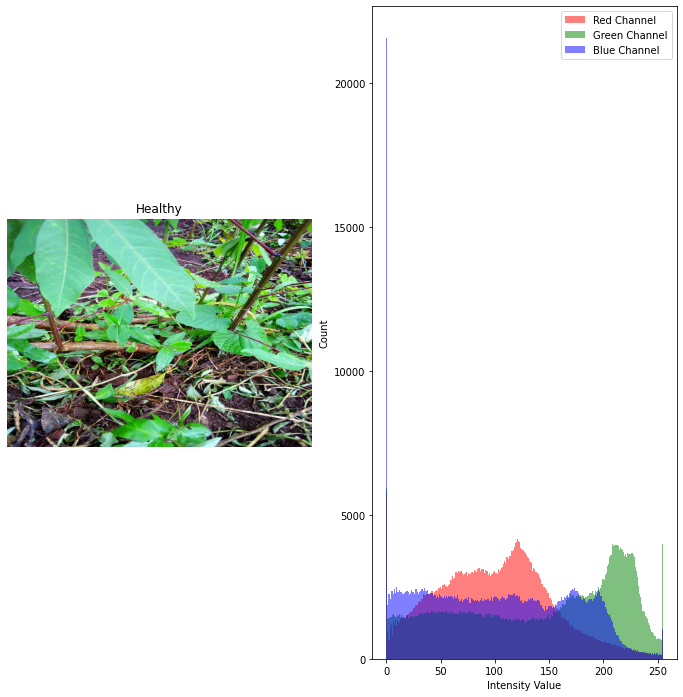

In [23]:
show_hist(healthy_imgs, 'Healthy')

In [24]:
show_box_plot(healthy_imgs, 'Healthy')

We can see the following distribution of median values for pixel intensities:

- Red: 108
- Green: 126
- Blue: 80

<h1 style='background:#2cab6c; border:0; color:white'><center>Cassava Mosaic Disease (CMD)</center></h1>

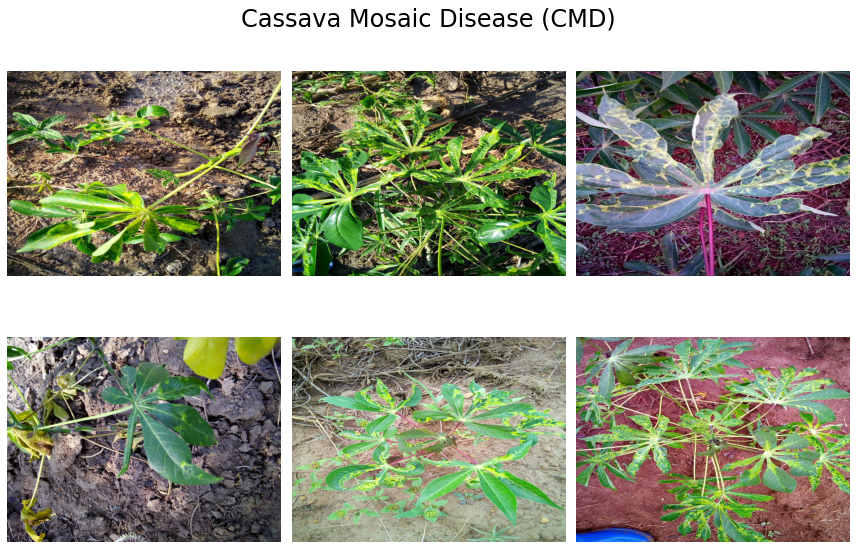

In [25]:
show_img(cmd_imgs, 'Cassava Mosaic Disease (CMD)')

Image dimensions: (600, 800)
Max pixel value: 255
Min pixel value: 0
Mean pixel value: 93
Standard deviation: 69


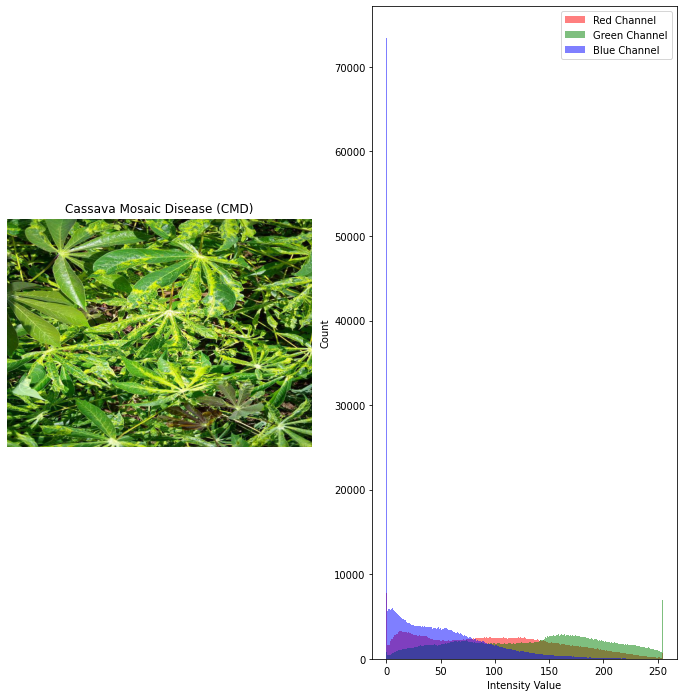

In [26]:
show_hist(cmd_imgs, 'Cassava Mosaic Disease (CMD)')

In [27]:
show_box_plot(cmd_imgs[:5000], 'Cassava Mosaic Disease (CMD)')

For this class, we only used the first 5000 images.

We can see the following distribution of median values for pixel intensities:

- Red: 109
- Green: 128
- Blue: 79

<h1 style='background:#2cab6c; border:0; color:white'><center>Cassava Green Mottle (CGM)</center></h1>

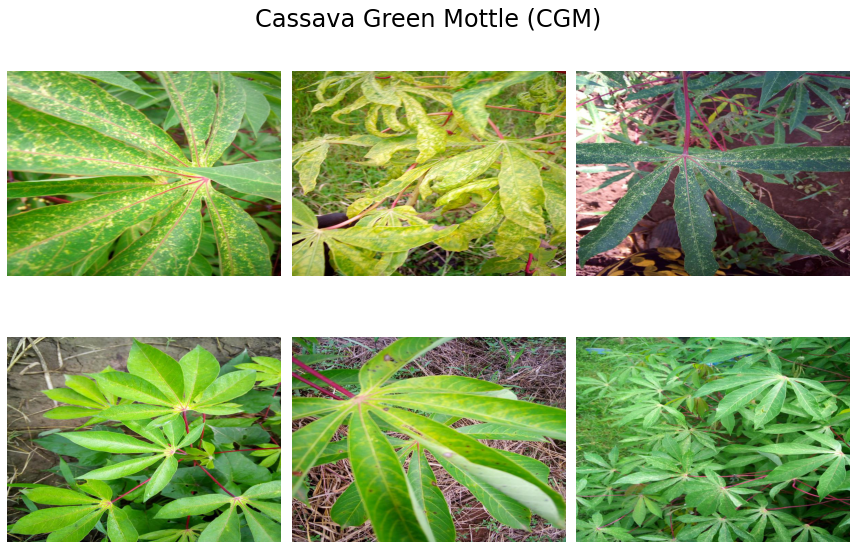

In [28]:
show_img(cgm_imgs, 'Cassava Green Mottle (CGM)')

Image dimensions: (600, 800)
Max pixel value: 255
Min pixel value: 0
Mean pixel value: 78
Standard deviation: 63


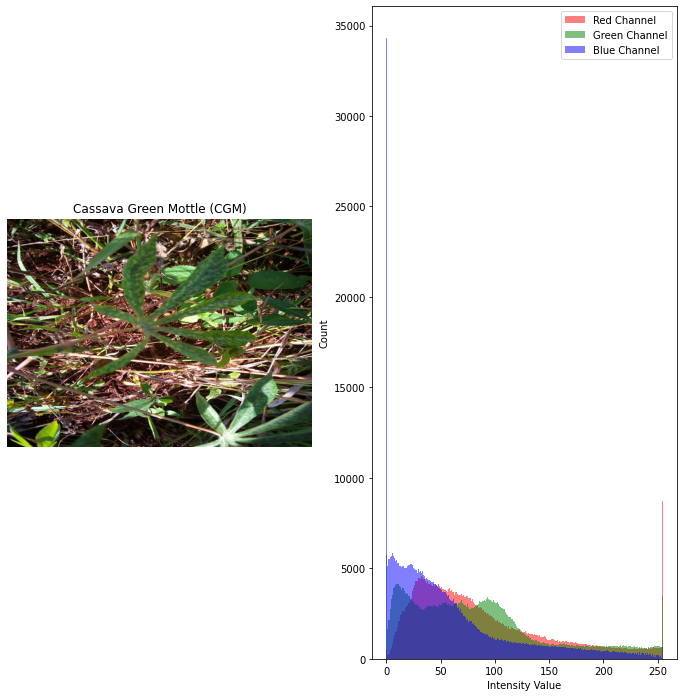

In [29]:
show_hist(cgm_imgs, 'Cassava Green Mottle (CGM)')

In [30]:
show_box_plot(cgm_imgs, 'Cassava Green Mottle (CGM)')

We can see the following distribution of median values for pixel intensities:

- Red: 113
- Green: 128
- Blue: 85

<h1 style='background:#2cab6c; border:0; color:white'><center>Cassava Brown Streak Disease (CBSD)</center></h1>

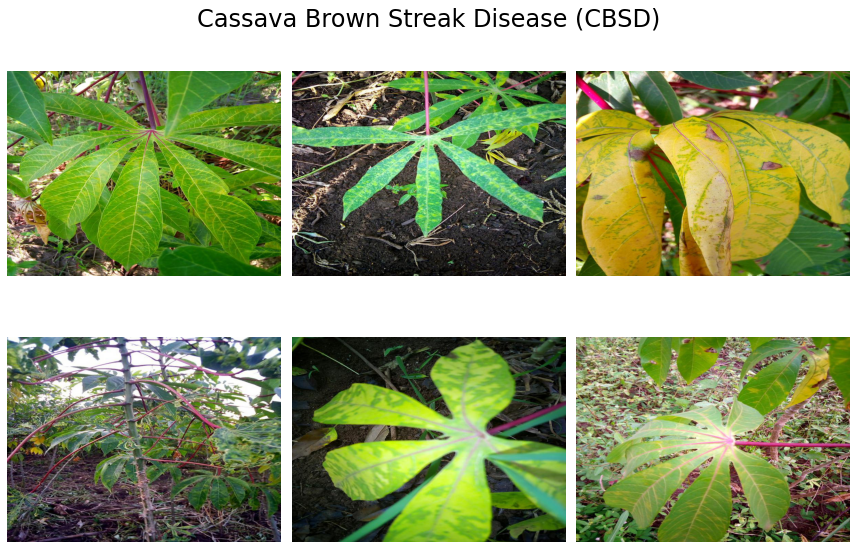

In [31]:
show_img(cbsd_imgs, 'Cassava Brown Streak Disease (CBSD)')

Image dimensions: (600, 800)
Max pixel value: 255
Min pixel value: 0
Mean pixel value: 96
Standard deviation: 58


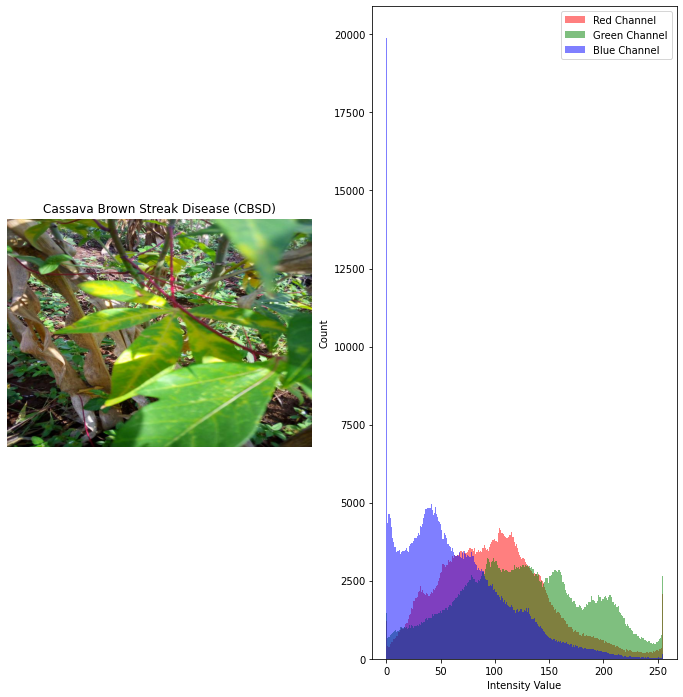

In [32]:
show_hist(cbsd_imgs, 'Cassava Brown Streak Disease (CBSD)')

In [33]:
show_box_plot(cbsd_imgs, 'Cassava Brown Streak Disease (CBSD)')

We can see the following distribution of median values for pixel intensities:

- Red: 106
- Green: 123
- Blue: 72

<h1 style='background:#2cab6c; border:0; color:white'><center>Cassava Bacterial Blight (CBB)</center></h1>

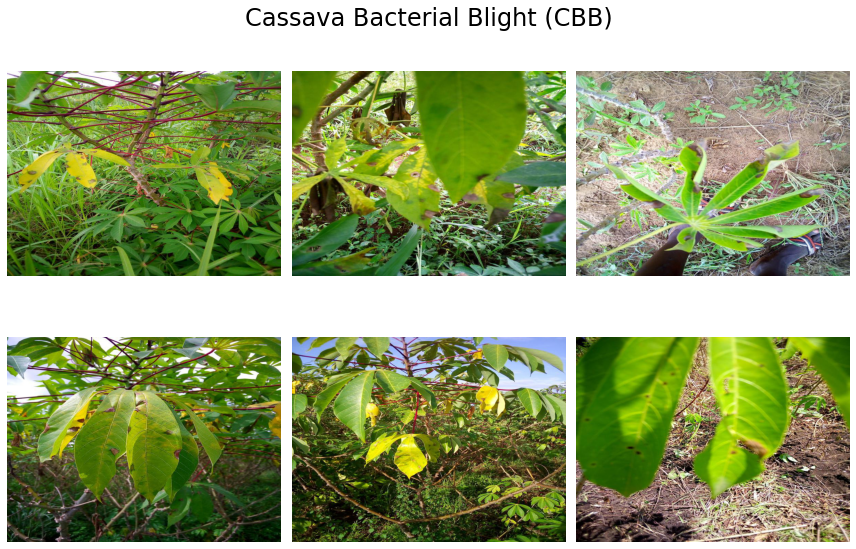

In [34]:
show_img(cbb, 'Cassava Bacterial Blight (CBB)')

Image dimensions: (600, 800)
Max pixel value: 255
Min pixel value: 0
Mean pixel value: 108
Standard deviation: 68


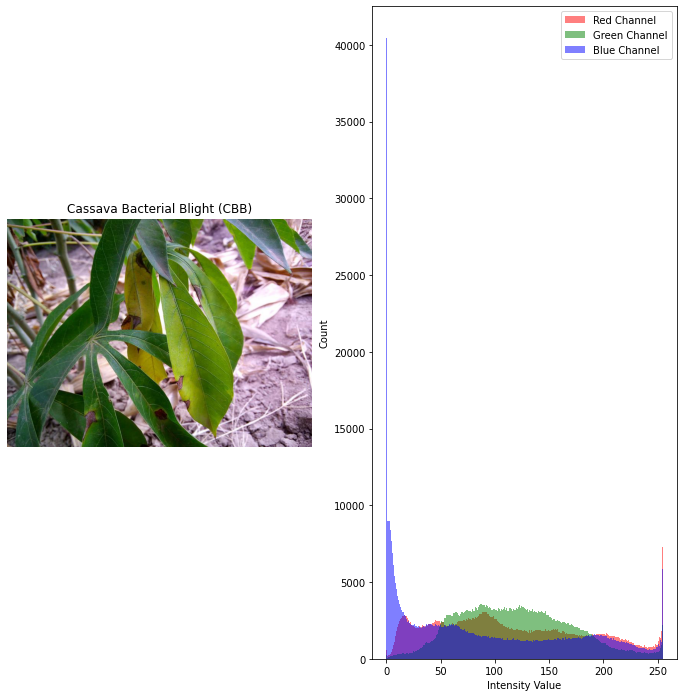

In [35]:
show_hist(cbb, 'Cassava Bacterial Blight (CBB)')

In [36]:
show_box_plot(cbb, 'Cassava Bacterial Blight (CBB)')

We can see the following distribution of median values for pixel intensities:

- Red: 102
- Green: 117
- Blue: 66

<h1 style='background:#2cab6c; border:0; color:white'><center>Conclusion</center></h1>

Dataset ini berisi 21.397 gambar. Terdapat 5 label kelas secara total, termasuk 4 label penyakit dan satu label kesehatan tanaman. Dari EDA, kita melihat bahwa label pelatihan sangat tidak seimbang: lebih dari 60% label pelatihan berada di kelas CMD, dan hanya sekitar 5% dari mereka berada di kelas CBB. Sejauh ini, kita tidak dapat memprediksi bagaimana ketidakseimbangan dalam dataset akan mempengaruhi akurasi model klasifikasi.
Ukuran gambar adalah 600 x 800 piksel. Dalam pelatihan, kita akan mengurangi ukuran gambar untuk melatih model dengan lebih efisien.
Selain itu, dengan menganalisis histogram saluran warna, kita melihat bahwa penyakit selalu disertai dengan perbedaan yang jelas dalam warna. Yaitu:
Gambar kelas CGM memiliki nilai median tertinggi dari saluran RGB;
Gambar kelas CBB memiliki nilai median terendah dari saluran RGB.
